# 5. Knn prediction of used car prices

## Context

I have written a from scratch algorithm for k nearest neighbors (knn) classification and tested it out on the Iris and Usedcar datasets very roughly. I wrote some (hopefully) useful helper functions to enable me to more easily clean and 'pivot' the data that I want to use for the KNN regression. Here I will apply those helper functions to work towards getting an output from the regression and looking at first pass accuracy of the predictions.

## Work outline

I will be updating module code to include new functions from the notebook #4 and adding extension functions to enable predicting a continuous variable. The [used car dataset](https://www.engineeringbigdata.com/wp-content/uploads/usedcars.csv) is from `www.engineeringbigdata.com`.

### Steps

1. import module from local filepath; load local data file
2. clean and 'pivot' data to enable running prediction code
3. split the dataset into training and test populations
3. run predict_category_from_knn on test set to generate predictions
4. find score for algorithm


## Result

TBD

## Next steps

Next I will consider how to scale and adjust weights to improve the model predictiveness.


## 1. import module from local filepath; load local data file

Also inspect the dataset to assess which are numerical features and which are categorical features


In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np

from knn_base import euclidean_distance
from knn_base import find_k_neighbors
from dataset_prep import raw_dataset_csv_to_nested_list
from dataset_prep import inspect_types_in_dataset
from dataset_prep import cast_numbers_to_float
from dataset_prep import split_dataset
from dataset_prep import norm_dataset
from dataset_prep import standardize_dataset

In [17]:
from dataset_prep import pivot_categorical_feature_columns

In [2]:
# load raw dataset
raw_dataset = raw_dataset_csv_to_nested_list('data/usedcars.csv')

In [3]:
raw_dataset[:5]

[['year', 'model', 'price', 'mileage', 'color', 'transmission'],
 ['2011', 'SEL', '21992', '7413', 'Yellow', 'AUTO'],
 ['2011', 'SEL', '20995', '10926', 'Gray', 'AUTO'],
 ['2011', 'SEL', '19995', '7351', 'Silver', 'AUTO'],
 ['2011', 'SEL', '17809', '11613', 'Gray', 'AUTO']]

In [6]:
raw_dataset_array = np.array(raw_dataset)

In [7]:
raw_dataset_array.shape

(151, 6)

In [8]:
for i in range(raw_dataset_array.shape[1]):
    print inspect_types_in_dataset(raw_dataset, i)

Counter({<type 'str'>: 151})
Counter({<type 'str'>: 151})
Counter({<type 'str'>: 151})
Counter({<type 'str'>: 151})
Counter({<type 'str'>: 151})
Counter({<type 'str'>: 151})


In [9]:
float_casted_list_dataset = cast_numbers_to_float(raw_dataset)

In [10]:
for i in range(raw_dataset_array.shape[1]):
    print inspect_types_in_dataset(float_casted_list_dataset, i)

Counter({<type 'float'>: 150, <type 'str'>: 1})
Counter({<type 'str'>: 151})
Counter({<type 'float'>: 150, <type 'str'>: 1})
Counter({<type 'float'>: 150, <type 'str'>: 1})
Counter({<type 'str'>: 151})
Counter({<type 'str'>: 151})


## 2. clean and 'pivot' data to enable running prediction code

Also cleanup, pivoting, normalization, and re-assembly the dataset to prepare for applying prediction functions


In [13]:
# price is the "objective" measurement
# will move that to the last position
num_features = raw_dataset_array[:, (0,3)]

In [14]:
num_features[:5]

array([['year', 'mileage'],
       ['2011', '7413'],
       ['2011', '10926'],
       ['2011', '7351'],
       ['2011', '11613']], dtype='|S12')

In [15]:
cat_features = raw_dataset_array[:, (1, 4, 5)]

In [16]:
cat_features[:5]

array([['model', 'color', 'transmission'],
       ['SEL', 'Yellow', 'AUTO'],
       ['SEL', 'Gray', 'AUTO'],
       ['SEL', 'Silver', 'AUTO'],
       ['SEL', 'Gray', 'AUTO']], dtype='|S12')

In [18]:
pivoted_models = pivot_categorical_feature_columns(cat_features, 0)
pivoted_colors = pivot_categorical_feature_columns(cat_features, 1)
pivoted_transmissions = pivot_categorical_feature_columns(cat_features, 2)

In [19]:
pivoted_models[:5]

[['SE', 'SES', 'SEL'],
 [0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0]]

In [20]:
pivoted_colors[:5]

[['Black',
  'Silver',
  'Red',
  'Blue',
  'Gray',
  'White',
  'Green',
  'Yellow',
  'Gold'],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]]

In [21]:
pivoted_transmissions[:5]

[['AUTO', 'MANUAL'], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]

In [22]:
len(num_features[1:])

150

In [23]:
num_features[1:].astype(np.float)[:5]

array([[ 2011.,  7413.],
       [ 2011., 10926.],
       [ 2011.,  7351.],
       [ 2011., 11613.],
       [ 2012.,  8367.]])

In [24]:
# have to remember that the 'post-cast-to-float' arrays won't have headers
norm_num_features = norm_dataset(num_features[1:].astype(np.float), 2)

In [25]:
norm_num_features[:5]

array([[0.91666667, 0.01736556],
       [0.91666667, 0.04132677],
       [0.91666667, 0.01694268],
       [0.91666667, 0.0460126 ],
       [1.        , 0.02387253]])

In [26]:
std_num_features = standardize_dataset(num_features[1:].astype(np.float), 2)

In [27]:
std_num_features[:5]

array([[ 1.03634013, -1.3702078 ],
       [ 1.03634013, -1.23957422],
       [ 1.03634013, -1.37251331],
       [ 1.03634013, -1.2140276 ],
       [ 1.49220822, -1.33473258]])

#### Putting the data back together as non-header, numerical feature data in three sets

Worth plotting some of the data at this point as well

**Key attributes:**

1. The column order is always consistent
    * model_year
    * mileage
    * transmissions (AUTO, MANUAL)
    * model_type (SE, SES, SEL)
    * colors (in consistent order) 
2. The 'objective' (price) is in the final column
3. No headers in the dataset (numpy needs consistent types in array)
4. Will have three versions of the same data
    

In [29]:
no_scaling_pivoted_dataset = np.concatenate(
    (num_features[1:, :].astype(np.float),
     np.array(pivoted_transmissions[1:]),
     np.array(pivoted_models[1:]),
     np.array(pivoted_colors[1:]),
     raw_dataset_array[1:, 2].astype(np.float)
    ),
    axis=1 
)

ValueError: all the input arrays must have same number of dimensions

In [30]:
num_features[1:, :].astype(np.float).shape

(150, 2)

In [32]:
np.array(pivoted_transmissions[1:]).shape

(150, 2)

In [33]:
np.array(pivoted_models[1:]).shape

(150, 3)

In [34]:
np.array(pivoted_colors[1:]).shape

(150, 9)

In [35]:
raw_dataset_array[1:, 2].astype(np.float).shape

(150,)

In [39]:
raw_dataset_array[1:, 2:2].astype(np.float).shape

(150, 0)

In [43]:
raw_dataset_array[1:, 2:3][:5]

array([['21992'],
       ['20995'],
       ['19995'],
       ['17809'],
       ['17500']], dtype='|S12')

In [44]:
no_scaling_pivoted_dataset = np.concatenate(
    (num_features[1:, :].astype(np.float),
     np.array(pivoted_transmissions[1:]),
     np.array(pivoted_models[1:]),
     np.array(pivoted_colors[1:]),
     raw_dataset_array[1:, 2:3].astype(np.float)
    ),
    axis=1 
)

In [45]:
no_scaling_pivoted_dataset[:5]

array([[2.0110e+03, 7.4130e+03, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 2.1992e+04],
       [2.0110e+03, 1.0926e+04, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0995e+04],
       [2.0110e+03, 7.3510e+03, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.9995e+04],
       [2.0110e+03, 1.1613e+04, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.7809e+04],
       [2.0120e+03, 8.3670e+03, 1.0000e+00, 0.0000e+

In [47]:
norm_num_features[1:, :].shape

(149, 2)

In [48]:
norm_scaling_pivoted_dataset = np.concatenate(
    (norm_num_features.astype(np.float),
     np.array(pivoted_transmissions[1:]),
     np.array(pivoted_models[1:]),
     np.array(pivoted_colors[1:]),
     raw_dataset_array[1:, 2:3].astype(np.float)
    ),
    axis=1 
)

In [49]:
norm_scaling_pivoted_dataset[:5]

array([[9.16666667e-01, 1.73655635e-02, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        2.19920000e+04],
       [9.16666667e-01, 4.13267672e-02, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.09950000e+04],
       [9.16666667e-01, 1.69426786e-02, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.99950000e+04],
       [9.16666667e-01, 4.60126047e-02, 1.00000000e+00, 0.000

In [50]:
std_scaling_pivoted_dataset = np.concatenate(
    (std_num_features.astype(np.float),
     np.array(pivoted_transmissions[1:]),
     np.array(pivoted_models[1:]),
     np.array(pivoted_colors[1:]),
     raw_dataset_array[1:, 2:3].astype(np.float)
    ),
    axis=1 
)

In [51]:
std_scaling_pivoted_dataset[:5]

array([[ 1.03634013e+00, -1.37020780e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  2.19920000e+04],
       [ 1.03634013e+00, -1.23957422e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  2.09950000e+04],
       [ 1.03634013e+00, -1.37251331e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.9

In [52]:
no_scaling_pivoted_dataset.shape

(150, 17)

In [53]:
norm_scaling_pivoted_dataset.shape

(150, 17)

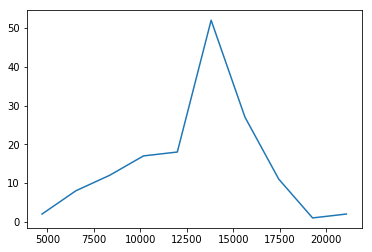

In [57]:
(n, bins) = np.histogram(no_scaling_pivoted_dataset[:, 16], bins=10)
plt.plot(.5*(bins[1:]+bins[:-1]), n)
plt.show()

In [60]:
header = raw_dataset[0][:2] + pivoted_transmissions[0] + pivoted_models[0] + pivoted_colors[0] + [raw_dataset[0][2]]

In [61]:
header

['year',
 'model',
 'AUTO',
 'MANUAL',
 'SE',
 'SES',
 'SEL',
 'Black',
 'Silver',
 'Red',
 'Blue',
 'Gray',
 'White',
 'Green',
 'Yellow',
 'Gold',
 'price']

In [62]:
len(header)

17

In [66]:
def plot_histogram_mplib(dataset_array, header, index, bins=10):
    """helper function to quickly plot histograms from dataset
    """
    (n, bins) = np.histogram(dataset_array[:, index], bins=bins)
    plt.plot(.5*(bins[1:]+bins[:-1]), n)
    plt.xlabel(header[index])
    plt.ylabel("frequency")
    plt.show()
    

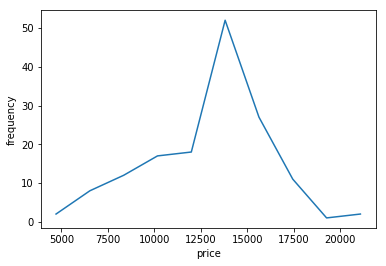

In [67]:
plot_histogram_mplib(
    no_scaling_pivoted_dataset,
    header,
    16
)

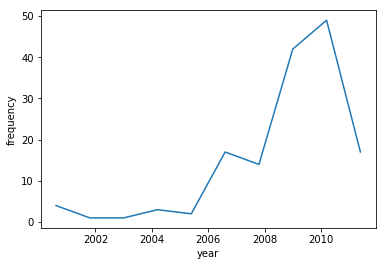

In [68]:
plot_histogram_mplib(
    no_scaling_pivoted_dataset,
    header,
    0
)

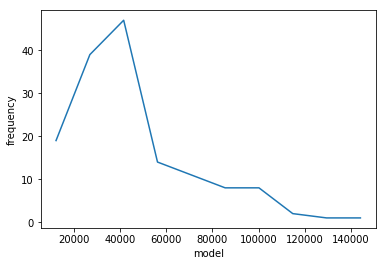

In [69]:
plot_histogram_mplib(
    no_scaling_pivoted_dataset,
    header,
    1
)

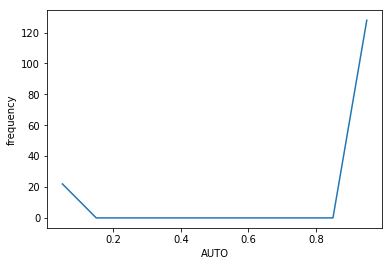

In [70]:
plot_histogram_mplib(
    no_scaling_pivoted_dataset,
    header,
    2
)

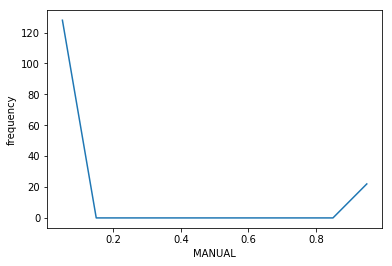

In [71]:
plot_histogram_mplib(
    no_scaling_pivoted_dataset,
    header,
    3
)

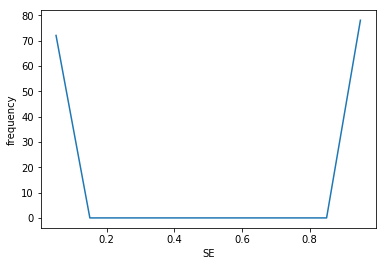

In [72]:
plot_histogram_mplib(
    no_scaling_pivoted_dataset,
    header,
    4
)

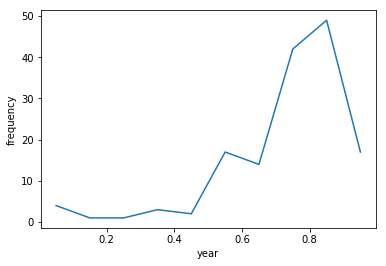

In [73]:
plot_histogram_mplib(
    norm_scaling_pivoted_dataset,
    header,
    0
)

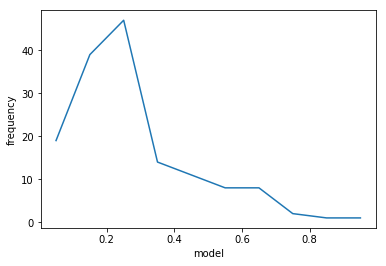

In [74]:
plot_histogram_mplib(
    norm_scaling_pivoted_dataset,
    header,
    1
)

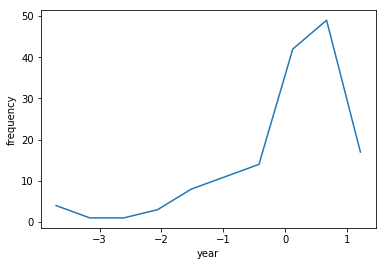

In [75]:
plot_histogram_mplib(
    std_scaling_pivoted_dataset,
    header,
    0
)

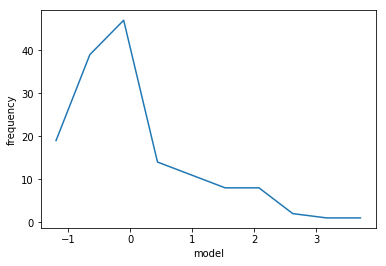

In [76]:
plot_histogram_mplib(
    std_scaling_pivoted_dataset,
    header,
    1
)

In [77]:
def quick_2x2_plot(dataset_array, header, indices):
    """helper function to quickly look at 2x2 of variables in dataset
    """
    plt.scatter(
        dataset_array[:, indices[0]].astype(float),
        dataset_array[:, indices[1]].astype(float)
    )
    plt.xlabel(header[indices[0]])
    plt.ylabel(header[indices[1]])
    plt.show()

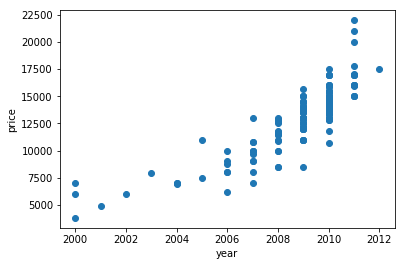

In [78]:
quick_2x2_plot(no_scaling_pivoted_dataset,
    header,
    (0,16))

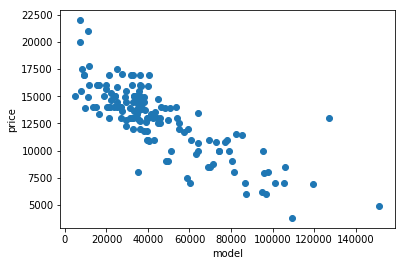

In [79]:
quick_2x2_plot(no_scaling_pivoted_dataset,
    header,
    (1,16))

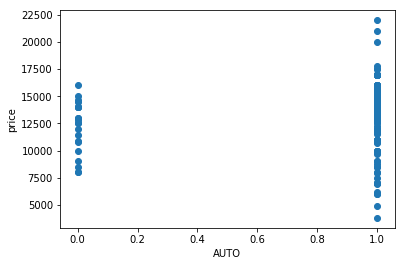

In [80]:
quick_2x2_plot(no_scaling_pivoted_dataset,
    header,
    (2,16))

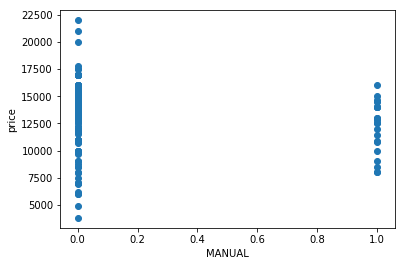

In [81]:
quick_2x2_plot(no_scaling_pivoted_dataset,
    header,
    (3,16))

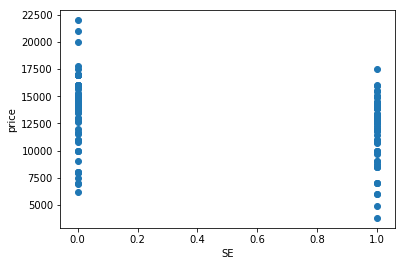

In [82]:
quick_2x2_plot(no_scaling_pivoted_dataset,
    header,
    (4,16))

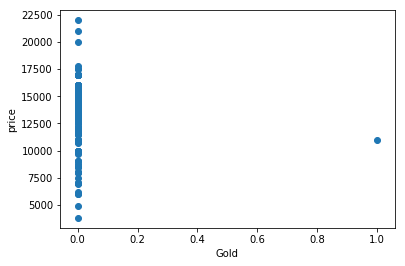

In [83]:
quick_2x2_plot(no_scaling_pivoted_dataset,
    header,
    (15,16))

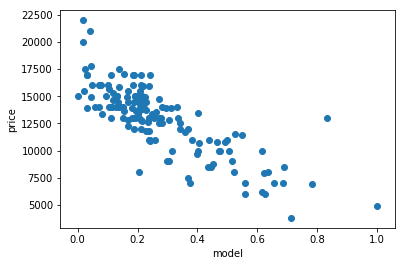

In [84]:
quick_2x2_plot(norm_scaling_pivoted_dataset,
    header,
    (1,16))

## Have the distinct suspicion that scaling the mileage will lead to worse predictions

Let's test that hypothesis!

Also [this](https://python-graph-gallery.com/110-basic-correlation-matrix-with-seaborn/) leads me to believe that I should be using the `seaborn` pairplot to visualize all the above things. Worth learning the more root way of building the plots at least once, I guess.

#### quick thought

It occurs to me that I should save the non-scaled, pivoted dataset to CSV so I can revisit without re-processing the data.

In [86]:
to_print_array = np.concatenate(
    (np.array([header]), no_scaling_pivoted_dataset.astype(np.str)),
    axis=0
)

In [87]:
to_print_array[:5]

array([['year', 'model', 'AUTO', 'MANUAL', 'SE', 'SES', 'SEL', 'Black',
        'Silver', 'Red', 'Blue', 'Gray', 'White', 'Green', 'Yellow',
        'Gold', 'price'],
       ['2011.0', '7413.0', '1.0', '0.0', '0.0', '0.0', '1.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0',
        '21992.0'],
       ['2011.0', '10926.0', '1.0', '0.0', '0.0', '0.0', '1.0', '0.0',
        '0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0',
        '20995.0'],
       ['2011.0', '7351.0', '1.0', '0.0', '0.0', '0.0', '1.0', '0.0',
        '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '19995.0'],
       ['2011.0', '11613.0', '1.0', '0.0', '0.0', '0.0', '1.0', '0.0',
        '0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0',
        '17809.0']], dtype='|S32')

In [88]:
np.savetxt("pivoted_usedcars.csv", to_print_array, delimiter=",")

TypeError: Mismatch between array dtype ('|S32') and format specifier ('%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e,%.18e')

In [89]:
to_print_array.shape

(151, 17)

In [90]:
np.savetxt("pivoted_usedcars.csv", to_print_array, delimiter=",", fmt='%s')

## 3. split the dataset into training and test populations

I will use the kwarg I put into the `split_dataset` that let's me pass in an external index array to split all three datasets the same way and compare performance apples-to-apples.

There are a couple of things I could poke at: feature selection, feature scaling.

i.e. Should I use all the features to predict or a subset? and How should I scale?

Downstream thing would be to figure out "Do I take an unweighted average of the k neighbors' prices?" or "Do I create a parameter (or vector space) by which I weight distances from my neighbors in my prices?"

For the "training/test" split I'll use 100:50 in this exercise.

In [91]:
split_array = np.concatenate((np.ones(100), np.zeros(50)), 0)
np.random.shuffle(split_array)

In [92]:
split_array[:5]

array([1., 0., 1., 0., 0.])

In [93]:
no_scale_training, no_scale_test = split_dataset(
    no_scaling_pivoted_dataset,
    100,
    split_array=split_array
)

In [94]:
no_scale_training[:5]

array([[2.0110e+03, 7.4130e+03, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 2.1992e+04],
       [2.0110e+03, 7.3510e+03, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.9995e+04],
       [2.0100e+03, 2.1026e+04, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.6995e+04],
       [2.0110e+03, 3.2655e+04, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.6995e+04],
       [2.0100e+03, 4.0539e+04, 1.0000e+00, 0.0000e+

In [95]:
no_scale_test[:5]

array([[2.0110e+03, 1.0926e+04, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0995e+04],
       [2.0110e+03, 1.1613e+04, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.7809e+04],
       [2.0120e+03, 8.3670e+03, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.7500e+04],
       [2.0100e+03, 2.5125e+04, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.7495e+04],
       [2.0110e+03, 2.7393e+04, 1.0000e+00, 0.0000e+

Let's predict the 4-NN for the first element in the test set

In [96]:
test_neighbors = find_k_neighbors(
    no_scale_test[0],
    no_scale_training,
    4,
    16
)

In [97]:
test_neighbors

[array([2.0110e+03, 1.1662e+04, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.5992e+04]),
 array([2.009e+03, 9.450e+03, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.395e+04]),
 array([2.011e+03, 9.388e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.695e+04]),
 array([2.0110e+03, 9.1990e+03, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.6992e+04])]

## 4. run predict_category_from_knn on test set to generate predictions

What does the prediction look like for a pure average of the neighbors' prices?

In [98]:
from math import fsum

In [99]:
test_price_prediction = fsum([row[16] for row in test_neighbors]) / 4.0

In [100]:
test_price_prediction

15971.0

In [101]:
# how far off am I?
no_scale_test[0][16] - test_price_prediction

5024.0

In [102]:
def predict_from_knn_average(query,
                             dataset,
                             k,
                             vector_length,
                             category_index=-1
                             ):
    """find knn and then predict outcome as mean of neighbors' values
    """
    if category_index < 0:
        category_index = vector_length
    neighbors = find_k_neighbors(query, dataset, k, vector_length)
    predicted_outcome = fsum([row[category_index] for row in neighbors]) / k
    return predicted_outcome

In [103]:
test_func_prediction = predict_from_knn_average(
    no_scale_test[0],
    no_scale_training,
    4,
    16
)

In [104]:
test_func_prediction

15971.0

#### now we are in business

Let's get a list of predictions with 'no-scale' dataset and use `euclidean distance` function to get a abs value score for how bad the predictions are

In [105]:
all_no_scale_test_predictions = []
for row in no_scale_test:
    prediction = predict_from_knn_average(
        row,
        no_scale_training,
        4,
        16
    )
    all_no_scale_test_predictions.append(prediction)

In [106]:
truth = [row[16] for row in no_scale_test]

In [107]:
print len(all_no_scale_test_predictions)
print len(truth)

50
50


In [108]:
no_scale_error = euclidean_distance(all_no_scale_test_predictions, truth, 50)

In [109]:
no_scale_error

13060.631234745126

#### Funny... it is hard to know whether this is "good" or "bad"

Would be useful to have a null hypothesis. Maybe "is this better than pure multivariate linear regression?" would be a useful benchmark.

Within the data here I can at least see if the error gets smaller or bigger for the scaled datasets.

In [110]:
norm_scaled_training, norm_scaled_test = split_dataset(
    norm_scaling_pivoted_dataset,
    100,
    split_array=split_array
)

In [111]:
norm_scaled_training[:5]

array([[9.16666667e-01, 1.73655635e-02, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        2.19920000e+04],
       [9.16666667e-01, 1.69426786e-02, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.99950000e+04],
       [8.33333333e-01, 1.10216081e-01, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.69950000e+04],
       [9.16666667e-01, 1.89534281e-01, 1.00000000e+00, 0.000

In [112]:
std_scaled_training, std_scaled_test = split_dataset(
    std_scaling_pivoted_dataset,
    100,
    split_array=split_array
)

In [113]:
std_scaled_training[:5]

array([[ 1.03634013e+00, -1.37020780e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  2.19920000e+04],
       [ 1.03634013e+00, -1.37251331e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.99950000e+04],
       [ 5.80472038e-01, -8.63998027e-01,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.6

## 5. find score for algorithm

I've got all the different scaled datasets split similarly I can look at the effect on the score of the different feature scalings and of cutting out some of the categorical values.

In [114]:
# run the code to predict all prices using the normed datasets
all_norm_scaled_test_predictions = []
for row in norm_scaled_test:
    prediction = predict_from_knn_average(
        row,
        norm_scaled_training,
        4,
        16
    )
    all_norm_scaled_test_predictions.append(prediction)

In [115]:
# run the code to predict all prices using the normed datasets
all_std_scaled_test_predictions = []
for row in std_scaled_test:
    prediction = predict_from_knn_average(
        row,
        std_scaled_training,
        4,
        16
    )
    all_std_scaled_test_predictions.append(prediction)

In [116]:
norm_scaled_error = euclidean_distance(all_norm_scaled_test_predictions, truth, 50)

In [117]:
std_scaled_error = euclidean_distance(all_std_scaled_test_predictions, truth, 50)

In [118]:
print no_scale_error
print norm_scaled_error
print std_scaled_error

13060.6312347
15738.4910431
9365.35532561


#### Hypothesis disproven! the standardization scaling set had lower error than the other predictions

That is pretty cool. I think that I will poke around on feature selection within that scaling.

In [119]:
# removing color from prediction should be easy
# I just have to reduce the vector length arg to trim
# values used in the prediction
# at what index do the colors start?
header

['year',
 'model',
 'AUTO',
 'MANUAL',
 'SE',
 'SES',
 'SEL',
 'Black',
 'Silver',
 'Red',
 'Blue',
 'Gray',
 'White',
 'Green',
 'Yellow',
 'Gold',
 'price']

In [120]:
header[:8]

['year', 'model', 'AUTO', 'MANUAL', 'SE', 'SES', 'SEL', 'Black']

In [122]:
# answer is seven 
print header[:7]

# this squares with the fact that there are nine colors
len(pivoted_colors[0])

['year', 'model', 'AUTO', 'MANUAL', 'SE', 'SES', 'SEL']


9

In [123]:
# will need to specify 'category_index'
# should be '16'
header[16]

'price'

In [124]:
all_std_scaled_no_colors_test_predictions = []
for row in std_scaled_test:
    prediction = predict_from_knn_average(
        row,
        std_scaled_training,
        4,
        7,
        category_index=16
    )
    all_std_scaled_no_colors_test_predictions.append(prediction)

In [125]:
std_scaled_no_colors_error = euclidean_distance(
    all_std_scaled_no_colors_test_predictions,
    truth,
    50
)

In [126]:
std_scaled_no_colors_error

8131.225015334406

In [127]:
# let's remove model type next
header[:4]

['year', 'model', 'AUTO', 'MANUAL']

In [128]:
all_std_scaled_no_colors_nor_models_test_predictions = []
for row in std_scaled_test:
    prediction = predict_from_knn_average(
        row,
        std_scaled_training,
        4,
        4,
        category_index=16
    )
    all_std_scaled_no_colors_nor_models_test_predictions.append(prediction)

In [129]:
std_scaled_no_colors_nor_models_error = euclidean_distance(
    all_std_scaled_no_colors_nor_models_test_predictions,
    truth,
    50
)

In [130]:
std_scaled_no_colors_nor_models_error

8953.306431844048

The error went up. Let's keep the model type data. A little trickier: let's selectively remove the transmission data.

In [133]:
print std_scaled_test[:4, :2]
print std_scaled_test[:4, 4:]

[[ 1.03634013 -1.23957422]
 [ 1.03634013 -1.2140276 ]
 [ 1.49220822 -1.33473258]
 [ 0.58047204 -0.71157359]]
[[0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  2.0995e+04]
 [0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  1.7809e+04]
 [1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  1.7500e+04]
 [0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  1.7495e+04]]


In [134]:
print header[:2]
print header[4:]

['year', 'model']
['SE', 'SES', 'SEL', 'Black', 'Silver', 'Red', 'Blue', 'Gray', 'White', 'Green', 'Yellow', 'Gold', 'price']


In [135]:
std_scaled_test_no_transmission = np.concatenate(
    (std_scaled_test[:, :2],
     std_scaled_test[:, 4:]),
    axis=1
)
std_scaled_training_no_transmission = np.concatenate(
    (std_scaled_training[:, :2],
     std_scaled_training[:, 4:]),
    axis=1
)

In [136]:
std_scaled_test_no_transmission.shape

(50, 15)

In [137]:
std_scaled_training_no_transmission.shape

(100, 15)

In [138]:
std_scaled_test.shape

(50, 17)

In [139]:
no_transmission_header = header[:2] + header[4:]

In [140]:
no_transmission_header

['year',
 'model',
 'SE',
 'SES',
 'SEL',
 'Black',
 'Silver',
 'Red',
 'Blue',
 'Gray',
 'White',
 'Green',
 'Yellow',
 'Gold',
 'price']

In [141]:
no_transmission_header[:5]

['year', 'model', 'SE', 'SES', 'SEL']

In [142]:
no_transmission_header[14]

'price'

In [143]:
all_std_scaled_no_colors_nor_transmission_test_predictions = []
for row in std_scaled_test_no_transmission:
    prediction = predict_from_knn_average(
        row,
        std_scaled_training_no_transmission,
        4,
        5,
        category_index=14
    )
    all_std_scaled_no_colors_nor_transmission_test_predictions.append(prediction)

In [144]:
std_scaled_no_colors_nor_transmission_error = euclidean_distance(
    all_std_scaled_no_colors_nor_transmission_test_predictions,
    truth,
    50
)

In [145]:
std_scaled_no_colors_nor_transmission_error

8540.117098875167

## Best predictions appear to be from std scaling of numerical features and de-selecting color data

This is from a process using test/training analysis, scaling, then feature selection